## Working with data

In [46]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [47]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
  root ="data",
  train = True,
  download = True,
  transform = ToTensor(),
)

# Download test data from open datasets,
test_data = datasets.FashionMNIST(
  root="data",
  train = False,
  download = True,
  transform=ToTensor(),
)

In [48]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"shape of X [N, C, H, W]: {X.shape}")
  print(f"shape of y: {y.shape} {y.type}")
  break


shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
shape of y: torch.Size([64]) <built-in method type of Tensor object at 0x17d15cb40>


## Creating Models

In [49]:
# Get cpu, gpu or mps device for training.
device = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"

)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512,10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits
  
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [52]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [53]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303643  [   64/60000]
loss: 2.293945  [ 6464/60000]
loss: 2.280457  [12864/60000]
loss: 2.265203  [19264/60000]
loss: 2.255441  [25664/60000]
loss: 2.229511  [32064/60000]
loss: 2.227628  [38464/60000]
loss: 2.206151  [44864/60000]
loss: 2.196387  [51264/60000]
loss: 2.154268  [57664/60000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 2.166437 

Epoch 2
-------------------------------
loss: 2.180491  [   64/60000]
loss: 2.173079  [ 6464/60000]
loss: 2.123580  [12864/60000]
loss: 2.122919  [19264/60000]
loss: 2.086372  [25664/60000]
loss: 2.026135  [32064/60000]
loss: 2.044775  [38464/60000]
loss: 1.983426  [44864/60000]
loss: 1.977143  [51264/60000]
loss: 1.893721  [57664/60000]
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.911402 

Epoch 3
-------------------------------
loss: 1.950596  [   64/60000]
loss: 1.922688  [ 6464/60000]
loss: 1.814858  [12864/60000]
loss: 1.832815  [19264/60000]
loss: 1.740941  [25664/60000]
loss: 1.685168  [32064/600

## Saving Models

In [54]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

In [55]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [56]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')




Predicted: "Ankle boot", Actual: "Ankle boot"


## Tensors: what are these and how to use them?

In [57]:
import numpy as np

### Initializing a Tensor

In [58]:
# Directly from data
data = [[1,2], [3,4]]
x_data = torch.tensor(data)

In [59]:
# From a Numpy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [60]:
# From another tensor:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")
x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.3113, 0.7818],
        [0.1021, 0.4849]]) 



In [61]:
#With random or constant values:
shape = (2, 3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")



Random Tensor: 
 tensor([[0.6078, 0.2804, 0.2838],
        [0.6219, 0.1621, 0.0458]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [62]:
# Tensor Attributes
tensor = torch.rand(3, 4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [63]:
# Tensor Operations
# We move our tensor to the GPU if available
if torch.cuda.is_available():
  tensor = tensor.to('cuda')
  print(f"Device tensor is stored on: {tensor.device}")


In [64]:
# Standard numpy-like indexing and slicing:
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


##### To join tensors, we can use torch.cat to concatenate a sequence of tensors along a specified dimension. Another tensor joining operation, torch.stack, is similar but subtly different from torch.cat.

In [65]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [66]:
# Multiplying Tensors
# This computes the element-wise product
print(f"tensor.mul(tensor) \n {tensor.mul(tensor)} \n")
# Alternative syntax:
print(f"tensor * tensor \n {tensor * tensor}")


tensor.mul(tensor) 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor * tensor 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


##### This computes the matrix multiplication between two tensors

In [67]:
print(f"tensor.matmul(tensor.T) \n {tensor.matmul(tensor.T)} \n")
# Alternative syntax:
print(f"tensor @ tensor.T \n {tensor @ tensor.T}")

tensor.matmul(tensor.T) 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 

tensor @ tensor.T 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


##### **In-place operations** Operations that have a _ suffix are in-place. For example: x.copy_(Y), x.t_(), will change x.

In [68]:
print(tensor, "\n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


### Datasets & DataLoaders

### Iterating and Visualizing the Dataset

In [70]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

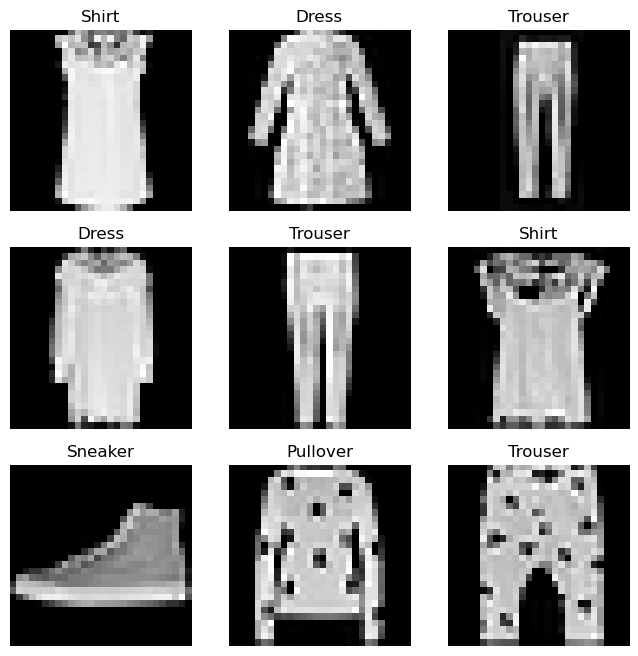

In [71]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

In [72]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __ init __

The __init__ is a special function used to set up newly created objects. It's part of a class definition and runs automatically when creating a new instance of the class.

##### The labels.csv file looks like:

In [80]:
# tshirt1.jpg, 0
# tshirt2.jpg, 0

# ankleboot999.jpg, 9

In [74]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

####  __ len __

 __ len __ is a special method that defines how the len() function behaves for class instances. Implementing __ len __ in your class enables objects to be passed to len(), returning an integer representing the object's size or number of elements.

In [76]:
# Example
def __len__(self):
    return len(self.img_labels)

### __ getitem __

The __getitem__ method in Python is a special function that defines how elements are accessed using square brackets ([]). Implementing __getitem__ in your class enables instances to support indexing and slicing, similar to built-in data structures like lists, tuples, and dictionaries.

In [77]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label


### Preparing your data for training with DataLoaders

In [78]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the Dataloader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


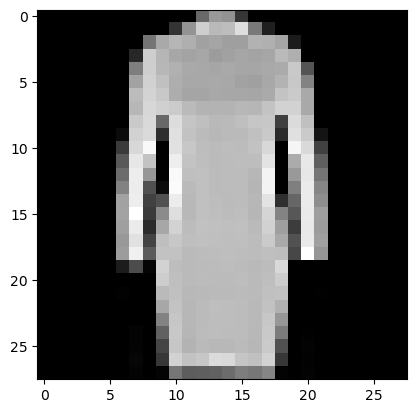

Label: 3


In [79]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Transforms

##### Data often requires preprocessing before it's suitable for training machine learning algorithms. Transforms help manipulate the data into the appropriate format.

TorchVision datasets include two parameters: 'transform' for modifying features and 'target_transform' for altering labels. These accept callables containing transformation logic. The torchvision.transforms module provides many ready-to-use transforms.

FashionMNIST features are in PIL Image format with integer labels. For training, we need normalized tensor features and one-hot encoded tensor labels. We use ToTensor and Lambda transforms to achieve these conversions.

In [81]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### To Tensor()

In [ ]:
#ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

### Lambda Transforms

In PyTorch, Lambda transforms apply custom, user-defined transformations to data within the torchvision.transforms module. This feature offers flexibility for preprocessing steps not covered by torchvision's standard transformations. The Lambda transform takes a function as an argument and applies it to each dataset element.

In [82]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

### Build the Neural Network

### A  neural network consists of interconnected nodes (neurons) that process and learn from data through weighted connections. 

In [83]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##### `torch.nn` is a module in PyTorch that provides essential tools for building and training neural networks. It includes pre-defined layers, loss functions, and utilities to streamline the creation, customization, and optimization of deep learning models.

### Get Device for Training

In [84]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Define the Class

In [85]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [86]:
# Build the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [87]:
# Forward pass
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8])


### Model Layers

##### Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network

In [88]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten, nn.Linear, nn.ReLU, nn.Sequential, nn.Softmax

nn.Flatten converts multi-dimensional input tensors into 1-dimensional tensors in neural networks, particularly in PyTorch.

nn.Linear, also called a fully connected or dense layer, is a key component in neural networks. It performs linear transformations on input data, mapping it to an output space.

nn.ReLU (Rectified Linear Unit) is a popular activation function that introduces non-linearity into neural networks, essential for learning complex patterns.

nn.Sequential is a PyTorch container module that allows stacking layers in order, useful for building simple feed-forward neural networks where each layer's output becomes the next layer's input.

nn.Softmax is an activation function used in the final layer of classification models. It transforms raw output scores (logits) into probabilities, making them easier to interpret and use for decision-making.

In [90]:
flatten =  nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())
#nn.Linear 
layer1 = nn.Linear (in_features=28*28, out_features = 20)
hidden1 = layer1(flat_image)
print(hidden1.size())
#nn.ReLU 
print(f"Before ReLU:  {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")
#nn.Sequential 
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
#nn.Softmax
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU:  tensor([[-0.3264,  0.2045, -0.2844, -0.4914, -0.1212,  0.0925, -0.5322, -0.4351,
          0.0932,  0.3811, -0.0162,  0.0242, -0.5544,  0.7543,  0.3187, -0.1645,
          0.5500,  0.6467,  0.1858,  0.0836],
        [-0.0144,  0.4569, -0.6450, -0.4188, -0.4306,  0.4422, -0.4905, -0.3342,
          0.3966,  0.1537,  0.3626,  0.3200, -0.3123,  0.6153,  0.3389, -0.3378,
          0.5751,  0.7267,  0.5071,  0.3118],
        [-0.1139,  0.3702, -0.2975, -0.4764,  0.0751,  0.3665, -0.4987, -0.4759,
          0.2069,  0.3965, -0.2714,  0.1578, -0.3417,  0.4921,  0.0848, -0.3314,
          0.5995,  0.5459,  0.1521,  0.1647]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.2045, 0.0000, 0.0000, 0.0000, 0.0925, 0.0000, 0.0000, 0.0932,
         0.3811, 0.0000, 0.0242, 0.0000, 0.7543, 0.3187, 0.0000, 0.5500, 0.6467,
         0.1858, 0.0836],
        [0.0000, 0.4569, 0.0000, 0.0000, 0.0000, 0.4422, 0.0000, 0.0000, 0.3966,
         0.

### Model Parameters

In [91]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0222,  0.0123, -0.0129,  ..., -0.0325, -0.0223, -0.0179],
        [-0.0140,  0.0023,  0.0340,  ..., -0.0356,  0.0184, -0.0194]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0051,  0.0109], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0049,  0.0060,  0.0289,  ..., -0.0018,  0.0399, -0.0032],
        [ 0.0007,  0.0043,  0.0098,  ..., -0.0324, -0.0035,  0.0187]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

### Automatic Differentiation with torch.autograd

In [2]:
import torch
x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad= True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [3]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x308fff850>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x309329d50>


### Computing Gradients

In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210],
        [0.1705, 0.2581, 0.0210]])
tensor([0.1705, 0.2581, 0.0210])


Note

 We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.

We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

### Disabling Gradient Tracking

By default, all tensors with requires_grad=True track their computational history and support gradient computation. However, in some cases, such as when applying a trained model to input data, we only need forward computations through the network. To stop tracking computations, we can wrap our code in a torch.no_grad() block.

In [5]:
z = torch.matmul(x,w)+b
print(z.requires_grad)

with torch.no_grad():
  z = torch.matmul(x,w)+b
print(z.requires_grad)

True
False


In [6]:
# Another way to achieve the same result is to use the detach() method on the tensor:
z = torch.matmul(x,w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


### Optional Reading: Tensor Gradients and Jacobian Products

In [7]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


### Optimizing Model Parameters

In [9]:
# Prerequisite Code
# we load the code from the previous sections on Datasets and Data Loaders and Build Model.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Hyperparameters

In [10]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Loss Function

In [11]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Full Implementation
We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301539  [   64/60000]
loss: 2.289985  [ 6464/60000]
loss: 2.278532  [12864/60000]
loss: 2.271997  [19264/60000]
loss: 2.235570  [25664/60000]
loss: 2.215268  [32064/60000]
loss: 2.213233  [38464/60000]
loss: 2.177849  [44864/60000]
loss: 2.176032  [51264/60000]
loss: 2.145626  [57664/60000]
Test Error: 
 Accuracy: 50.6%, Avg loss: 2.138972 

Epoch 2
-------------------------------
loss: 2.147517  [   64/60000]
loss: 2.137679  [ 6464/60000]
loss: 2.080538  [12864/60000]
loss: 2.096019  [19264/60000]
loss: 2.030731  [25664/60000]
loss: 1.976007  [32064/60000]
loss: 1.994684  [38464/60000]
loss: 1.913609  [44864/60000]
loss: 1.914102  [51264/60000]
loss: 1.844186  [57664/60000]
Test Error: 
 Accuracy: 57.7%, Avg loss: 1.842278 

Epoch 3
-------------------------------
loss: 1.878593  [   64/60000]
loss: 1.849953  [ 6464/60000]
loss: 1.727505  [12864/60000]
loss: 1.766215  [19264/60000]
loss: 1.652912  [25664/60000]
loss: 1.612660  [32064/600

### Save and Load the Model
In this section we will look at how to persist model state with saving, loading and running model predictions.



In [19]:
import torch
import torchvision.models as models

### Saving and Loading Model Weights

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:



In [20]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/anjalisuman/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.7MB/s] 


To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In the code below, we set weights_only=True to limit the functions executed during unpickling to only those necessary for loading weights. Using weights_only=True is considered a best practice when loading weights.

In [21]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

NOTE:
be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

### Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass model (and not model.state_dict()) to the saving function:

In [22]:
torch.save(model, 'model.pth')


We can then load the model as demonstrated below.

As described in Saving and loading torch.nn.Modules, saving state_dict``s is considered the best practice. However, below we use ``weights_only=False because this involves loading the model, which is a legacy use case for torch.save.

In [23]:
model = torch.load('model.pth', weights_only=False),

Note: 
This approach uses Python pickle module when serializing the model, thus it relies on the actual class definition to be available when loading the model.

### Introduction to Pytorch

In [1]:
import torch

Few basic tensor manipulations

In [2]:
z = torch.zeros(5,3)
print(z)
print(z.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
torch.float32


We created a 5x3 matrix filled with zeros, and query its datatype to find out that the zeros are 32-bit floating point numbers, whoich is the default Pytorch.

What if you wanted integers instead? You can always override the default:

In [8]:
i = torch.ones((5,3), dtype=torch.int16)
print(i)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)


In [9]:
torch.manual_seed(1729)
r1 = torch.rand(2, 2)
print('A random tensor:')
print(r1)

r2 = torch.rand(2, 2)
print('\nA different random tensor:')
print(r2) # new values

torch.manual_seed(1729)
r3 = torch.rand(2, 2)
print('\nShould match r1:')
print(r3) # repeat values of r1 because of re-seed

A random tensor:
tensor([[0.3126, 0.3791],
        [0.3087, 0.0736]])

A different random tensor:
tensor([[0.4216, 0.0691],
        [0.2332, 0.4047]])

Should match r1:
tensor([[0.3126, 0.3791],
        [0.3087, 0.0736]])


Pytorch tensors perform arithmetic operations intuitively. Tensors of similar shapes may be added, multiplied, etc. Operations with scalars are distributed over the tensor:

In [14]:
ones = torch.ones(2,3)
print(ones)

twos = torch.ones(2, 3)* 2 # every element is multiplied by 2
print(twos)

threes = ones+twos # addition allowed because shapes are similar
print(threes) # tensors are added element-wise
print(threes.shape) # this has the same dimensions as input tensors

r1 = torch.rand(2, 3)
r2 = torch.rand(3, 2)
# uncomment this line to get a run time error
# r3 = r1 + r2 

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 2., 2.],
        [2., 2., 2.]])
tensor([[3., 3., 3.],
        [3., 3., 3.]])
torch.Size([2, 3])


Here's a small sample of the mathematical operations available:

In [18]:
r = (torch.rand(2, 2) - 0.5) * 2 # values between -1 and 1
print('A random matrix, r:')
print(r)

# Common mathematical operations are supported:
print('\nAbsolute value of r:')
print(torch.abs(r))

#...as are trigonometric functions:
print('\nInverse sine of r:')
print(torch.asin(r))

#...and linear algebra operations like determinant and singular value decomposition 
print('\nDeterminant of r:')
print(torch.det(r))
print('\nSingular value decomposition of r:')
print(torch.svd(r))

#...and statistical and aggregate operations:
print('\nAverage and standard deviation of r:')
print(torch.std_mean(r))
print('\nMaximum value of r:')
print(torch.max(r))


A random matrix, r:
tensor([[-0.2629, -0.1986],
        [ 0.4439,  0.6434]])

Absolute value of r:
tensor([[0.2629, 0.1986],
        [0.4439, 0.6434]])

Inverse sine of r:
tensor([[-0.2660, -0.1999],
        [ 0.4600,  0.6989]])

Determinant of r:
tensor(-0.0810)

Singular value decomposition of r:
torch.return_types.svd(
U=tensor([[-0.3764,  0.9265],
        [ 0.9265,  0.3764]]),
S=tensor([0.8428, 0.0961]),
V=tensor([[ 0.6054, -0.7959],
        [ 0.7959,  0.6054]]))

Average and standard deviation of r:
(tensor(0.4552), tensor(0.1565))

Maximum value of r:
tensor(0.6434)


### Pytorch Models

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Looking over this code, you should be able to spot some structural similarities with the diagram above.

This demonstrates the structure of a typical PyTorch model:

It inherits from torch.nn.Module - modules may be nested - in fact, even the Conv2d and Linear layer classes inherit from torch.nn.Module.

A model will have an __init__() function, where it instantiates its layers, and loads any data artifacts it might need (e.g., an NLP model might load a vocabulary).

A model will have a forward() function. This is where the actual computation happens: An input is passed through the network layers and various functions to generate an output.

Other than that, you can build out your model class like any other Python class, adding whatever properties and methods you need to support your model’s computation.

Let’s instantiate this object and run a sample input through it.

In [23]:
net = LeNet()
print(net)                         # what does the object tell us about itself?

input = torch.rand(1, 1, 32, 32)   # stand-in for a 32x32 black & white image
print('\nImage batch shape:')
print(input.shape)

output = net(input)                # we don't call forward() directly
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])

Raw output:
tensor([[ 0.0079,  0.0452, -0.0448,  0.0572,  0.0418,  0.0428, -0.0063,  0.1045,
          0.0045, -0.0551]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


There are a few important things happening above:

First, we instantiate the LeNet class, and we print the net object. A subclass of torch.nn.Module will report the layers it has created and their shapes and parameters. This can provide a handy overview of a model if you want to get the gist of its processing.

Below that, we create a dummy input representing a 32x32 image with 1 color channel. Normally, you would load an image tile and convert it to a tensor of this shape.

You may have noticed an extra dimension to our tensor - the batch dimension. PyTorch models assume they are working on batches of data - for example, a batch of 16 of our image tiles would have the shape (16, 1, 32, 32). Since we’re only using one image, we create a batch of 1 with shape (1, 1, 32, 32).

We ask the model for an inference by calling it like a function: net(input). The output of this call represents the model’s confidence that the input represents a particular digit. (Since this instance of the model hasn’t learned anything yet, we shouldn’t expect to see any signal in the output.) Looking at the shape of output, we can see that it also has a batch dimension, the size of which should always match the input batch dimension. If we had passed in an input batch of 16 instances, output would have a shape of (16, 10).



### Datasets and Dataloaders

Below, we’re going to demonstrate using one of the ready-to-download, open-access datasets from TorchVision, how to transform the images for consumption by your model, and how to use the DataLoader to feed batches of data to your model.

The first thing we need to do is transform our incoming images into a PyTorch tensor.



In [24]:
#%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

Here, we specify two transformations for our input:

transforms.ToTensor() converts images loaded by Pillow into PyTorch tensors.

transforms.Normalize() adjusts the values of the tensor so that their average is zero and their standard deviation is 1.0. Most activation functions have their strongest gradients around x = 0, so centering our data there can speed learning. The values passed to the transform are the means (first tuple) and the standard deviations (second tuple) of the rgb values of the images in the dataset. You can calculate these values yourself by running these few lines of code:

from torch.utils.data import ConcatDataset transform = transforms.Compose([transforms.ToTensor()]) trainset = torchvision.datasets.CIFAR10(root=’./data’, train=True,

download=True, transform=transform)

#stack all train images together into a tensor of shape #(50000, 3, 32, 32) x = torch.stack([sample[0] for sample in ConcatDataset([trainset])])

#get the mean of each channel mean = torch.mean(x, dim=(0,2,3)) #tensor([0.4914, 0.4822, 0.4465]) std = torch.std(x, dim=(0,2,3)) #tensor([0.2470, 0.2435, 0.2616])

There are many more transforms available, including cropping, centering, rotation, and reflection.

Next, we’ll create an instance of the CIFAR10 dataset. This is a set of 32x32 color image tiles representing 10 classes of objects: 6 of animals (bird, cat, deer, dog, frog, horse) and 4 of vehicles (airplane, automobile, ship, truck):

In [27]:
trainset = torchvision.datasets.CIFAR10(root= './data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [02:05<00:00, 1354593.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


This is an example of creating a dataset object in PyTorch. Downloadable datasets (like CIFAR-10 above) are subclasses of torch.utils.data.Dataset. Dataset classes in PyTorch include the downloadable datasets in TorchVision, Torchtext, and TorchAudio, as well as utility dataset classes such as torchvision.datasets.ImageFolder, which will read a folder of labeled images. You can also create your own subclasses of Dataset.

When we instantiate our dataset, we need to tell it a few things:

The filesystem path to where we want the data to go.

Whether or not we are using this set for training; most datasets will be split into training and test subsets.

Whether we would like to download the dataset if we haven’t already.

The transformations we want to apply to the data.

Once your dataset is ready, you can give it to the DataLoader:

In [28]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

A  Dataset subclass wraps access to the data, and is specialized to the type of data it’s serving. The DataLoader knows nothing about the data, but organizes the input tensors served by the Dataset into batches with the parameters you specify.

In the example above, we’ve asked a DataLoader to give us batches of 4 images from trainset, randomizing their order (shuffle=True), and we told it to spin up two workers to load data from disk.

It’s good practice to visualize the batches your DataLoader serves:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car  ship  ship horse


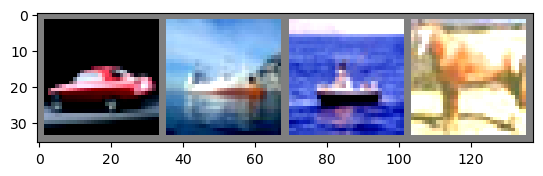

In [29]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Training Your PyTorch Model

Let's put all the pieces together, and train a model:

In [30]:
#%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt 
import numpy as np

First, we'll need training and test datasets. If you haven't already, run the cell below to make sure the dataset is downloaded. (It may take a minute.)

In [32]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root= './data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We'll run our check on the output from DataLoader:

truck   cat  ship  bird


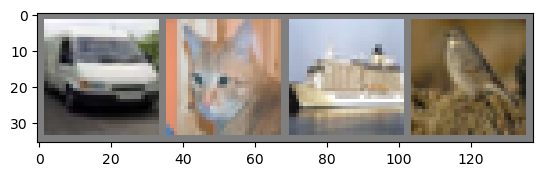

In [35]:
import matplotlib.pyplot as plt
import numpy as np
#functions to show an image

def imshow(img):
  img = img/ 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

#get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

This is the model we'll train.If it looks familiar, that's because it's a variant of LeNet

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

The last ingredients we need are a loss function and an optimizer:

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

The loss function, as discussed earlier in this video, is a measure of how far from our ideal output the model’s prediction was. Cross-entropy loss is a typical loss function for classification models like ours.

The optimizer is what drives the learning. Here we have created an optimizer that implements stochastic gradient descent, one of the more straightforward optimization algorithms. Besides parameters of the algorithm, like the learning rate (lr) and momentum, we also pass in net.parameters(), which is a collection of all the learning weights in the model - which is what the optimizer adjusts.

Finally, all of this is assembled into the training loop. Go ahead and run this cell, as it will likely take a few minutes to execute:



In [38]:
for epoch in range(2): # loop over the dataset multiple times


  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    #get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()
    #forward+ backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: #print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i+1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.233
[1,  4000] loss: 1.898
[1,  6000] loss: 1.681
[1,  8000] loss: 1.564
[1, 10000] loss: 1.535
[1, 12000] loss: 1.472
[2,  2000] loss: 1.406
[2,  4000] loss: 1.375
[2,  6000] loss: 1.358
[2,  8000] loss: 1.316
[2, 10000] loss: 1.299
[2, 12000] loss: 1.282
Finished Training


Here, we are doing only 2 training epochs (line 1) - that is, two passes over the training dataset. Each pass has an inner loop that iterates over the training data (line 4), serving batches of transformed input images and their correct labels.

Zeroing the gradients (line 9) is an important step. Gradients are accumulated over a batch; if we do not reset them for every batch, they will keep accumulating, which will provide incorrect gradient values, making learning impossible.

In line 12, we ask the model for its predictions on this batch. In the following line (13), we compute the loss - the difference between outputs (the model prediction) and labels (the correct output).

In line 14, we do the backward() pass, and calculate the gradients that will direct the learning.

In line 15, the optimizer performs one learning step - it uses the gradients from the backward() call to nudge the learning weights in the direction it thinks will reduce the loss.

The remainder of the loop does some light reporting on the epoch number, how many training instances have been completed, and what the collected loss is over the training loop.

Note that the loss is monotonically descending, indicating that our model is continuing to improve its performance on the training dataset.

As a final step, we should check that the model is actually doing general learning, and not simply “memorizing” the dataset. This is called overfitting, and usually indicates that the dataset is too small (not enough examples for general learning), or that the model has more learning parameters than it needs to correctly model the dataset.

This is the reason datasets are split into training and test subsets - to test the generality of the model, we ask it to make predictions on data it hasn’t trained on:

In [39]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


If you followed along, you should see that the model is roughly 50% accurate at this point. That’s not exactly state-of-the-art, but it’s far better than the 10% accuracy we’d expect from a random output. This demonstrates that some general learning did happen in the model.



### Introduction to PyTorch Tensors

Tensors are the central data abstraction in PyTorch. This interactive notebook provides an in-depth introduction to the torch.Tensor class.

First things first, let's import the PyTorch module.We'll also add Python's math module to facilitate some of the examples.

In [41]:
import torch
import math

### Creating Tensors

The simplest way to create a tensor is with the torch.empty() call:

In [42]:
x = torch.empty(3,4)
print(type(x))
print(x)

<class 'torch.Tensor'>
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


Let’s unpack what we just did:

We created a tensor using one of the numerous factory methods attached to the torch module.

The tensor itself is 2-dimensional, having 3 rows and 4 columns.

The type of the object returned is torch.Tensor, which is an alias for torch.FloatTensor; by default, PyTorch tensors are populated with 32-bit floating point numbers. (More on data types below.)

You will probably see some random-looking values when printing your tensor. The torch.empty() call allocates memory for the tensor, but does not initialize it with any values - so what you’re seeing is whatever was in memory at the time of allocation.

A brief note about tensors and their number of dimensions, and terminology:

You will sometimes see a 1-dimensional tensor called a vector.

Likewise, a 2-dimensional tensor is often referred to as a matrix.

Anything with more than two dimensions is generally just called a tensor.

More often than not, you’ll want to initialize your tensor with some value. Common cases are all zeros, all ones, or random values, and the torch module provides factory methods for all of these:

In [43]:
zeros = torch.zeros(2, 3)
print(zeros)

ones = torch.ones(2, 3)
print(ones)

torch.manual_seed(1729)
random = torch.rand(2,3)
print(random)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])


The factory methods all do just what you’d expect - we have a tensor full of zeros, another full of ones, and another with random values between 0 and 1.

### Random Tensors and Seeding

Speaking of the random tensor, did you notice the call to torch.manual_seed() immediately preceding it? Initializing tensors, such as a model’s learning weights, with random values is common but there are times - especially in research settings - where you’ll want some assurance of the reproducibility of your results. Manually setting your random number generator’s seed is the way to do this. Let’s look more closely:

In [44]:
torch.manual_seed(1729)
random1 = torch.rand(2, 3)
print(random1)

random2 = torch.rand(2, 3)
print(random2)

torch.manual_seed(1729)
random3 = torch.rand(2, 3)
print(random3)

random4 = torch.rand(2, 3)
print(random4)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])
tensor([[0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938]])
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])
tensor([[0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938]])


What you should see above is that random1 and random3 carry identical values, as do random2 and random4. Manually setting the RNG’s seed resets it, so that identical computations depending on random number should, in most settings, provide identical results.

### Tensor Shapes

Often, when you’re performing operations on two or more tensors, they will need to be of the same shape - that is, having the same number of dimensions and the same number of cells in each dimension. For that, we have the torch.*_like() methods:

In [45]:
x = torch.empty(2, 2, 3)
print(x.shape)
print(x)

empty_like_x = torch.empty_like(x)
print(empty_like_x.shape)
print(empty_like_x)

zeros_like_x = torch.zeros_like(x)
print(zeros_like_x.shape)
print(zeros_like_x)

ones_like_x = torch.ones_like(x)
print(ones_like_x.shape)
print(ones_like_x)

rand_like_x = torch.rand_like(x)
print(rand_like_x.shape)
print(rand_like_x)

torch.Size([2, 2, 3])
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])
torch.Size([2, 2, 3])
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])
torch.Size([2, 2, 3])
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])
torch.Size([2, 2, 3])
tensor([[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]])
torch.Size([2, 2, 3])
tensor([[[0.6128, 0.1519, 0.0453],
         [0.5035, 0.9978, 0.3884]],

        [[0.6929, 0.1703, 0.1384],
         [0.4759, 0.7481, 0.0361]]])


The first new thing in the code cell above is the use of the .shape property on a tensor. This property contains a list of the extent of each dimension of a tensor - in our case, x is a three-dimensional tensor with shape 2 x 2 x 3.

Below that, we call the .empty_like(), .zeros_like(), .ones_like(), and .rand_like() methods. Using the .shape property, we can verify that each of these methods returns a tensor of identical dimensionality and extent.

The last way to create a tensor that will cover is to specify its data directly from a PyTorch collection:

In [46]:
some_constants = torch.tensor([[3.1415926, 2.71828], [1.61803, 0.0072897]])
print(some_constants)

some_integers = torch.tensor((2, 3, 5, 7, 11, 13, 17, 19))
print(some_integers)

more_integers = torch.tensor(((2, 4, 6), [3, 6, 9]))
print(more_integers)

tensor([[3.1416, 2.7183],
        [1.6180, 0.0073]])
tensor([ 2,  3,  5,  7, 11, 13, 17, 19])
tensor([[2, 4, 6],
        [3, 6, 9]])


Using torch.tensor() is the most straightforward way to create a tensor if you already have data in a Python tuple or list. As shown above, nesting the collections will result in a multi-dimensional tensor.

In [48]:
torch.tensor(4)

tensor(4)

### Tensor Data Types

Setting the datatype of a tensor is possible a couple of ways:

In [49]:
a = torch.ones((2, 3), dtype=torch.int16)
print(a)

b = torch.rand((2, 3), dtype=torch.float) * 20.
print(b)

c = b.to(torch.int32)
print(c)

tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)
tensor([[10.1244, 16.9389,  5.1768],
        [ 5.4131,  8.2296, 13.6772]])
tensor([[10, 16,  5],
        [ 5,  8, 13]], dtype=torch.int32)


The simplest way to set the underlying data type of a tensor is with an optional argument at creation time. In the first line of the cell above, we set dtype=torch.int16 for the tensor a. When we print a, we can see that it’s full of 1 rather than 1. - Python’s subtle cue that this is an integer type rather than floating point.

Another thing to notice about printing a is that, unlike when we left dtype as the default (32-bit floating point), printing the tensor also specifies its dtype.

You may have also spotted that we went from specifying the tensor’s shape as a series of integer arguments, to grouping those arguments in a tuple. This is not strictly necessary - PyTorch will take a series of initial, unlabeled integer arguments as a tensor shape - but when adding the optional arguments, it can make your intent more readable.

The other way to set the datatype is with the .to() method. In the cell above, we create a random floating point tensor b in the usual way. Following that, we create c by converting b to a 32-bit integer with the .to() method. Note that c contains all the same values as b, but truncated to integers.

### Math & Logic with PyTorch Tensors

Now that you know some of the ways to create a tensor… what can you do with them?

Let’s look at basic arithmetic first, and how tensors interact with simple scalars:



In [50]:
ones = torch.zeros(2, 2) + 1
twos = torch.ones(2, 2) * 2
threes = (torch.ones(2, 2) * 7 - 1)/2
fours = twos ** 2
sqrt2s = twos ** 0.5

print(ones)
print(twos)
print(threes)
print(fours)
print(sqrt2s)

tensor([[1., 1.],
        [1., 1.]])
tensor([[2., 2.],
        [2., 2.]])
tensor([[3., 3.],
        [3., 3.]])
tensor([[4., 4.],
        [4., 4.]])
tensor([[1.4142, 1.4142],
        [1.4142, 1.4142]])


As you can see above, arithmetic operations between tensors and scalars, such as addition, subtraction, multiplication, division, and exponentiation are distributed over every element of the tensor. Because the output of such an operation will be a tensor, you can chain them together with the usual operator precedence rules, as in the line where we create threes.

Similar operations between two tensors also behave like you’d intuitively expect:



In [51]:
powers2 = twos ** torch.tensor([[1, 2], [3, 4]])
print(powers2)

fives = ones + fours
print(fives)

dozens = threes * fours
print(dozens)

tensor([[ 2.,  4.],
        [ 8., 16.]])
tensor([[5., 5.],
        [5., 5.]])
tensor([[12., 12.],
        [12., 12.]])


It’s important to note here that all of the tensors in the previous code cell were of identical shape. What happens when we try to perform a binary operation on tensors if dissimilar shape?

In [52]:
# The following cell throws a run-time error. This is intentional

a = torch.rand(2, 3)
b = torch.rand(3, 2)

print(a+b)

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In the general case, you cannot operate on tensors of different shape this way, even in a case like the cell above, where the tensors have an identical number of elements.



### In Brief: Tensor Broadcasting

If you are familiar with broadcasting semantics in Numpy ndarrays, you'll find the same rules apply here.

The exception to the same-shapes rule is tensor broadcasting. here's an example:


In [53]:
rand = torch.rand(2, 4)
doubled = rand * (torch.ones(1,4) * 2)

print(rand)
print(doubled)

tensor([[0.6865, 0.3614, 0.6493, 0.2633],
        [0.4762, 0.0548, 0.2024, 0.5731]])
tensor([[1.3730, 0.7228, 1.2987, 0.5266],
        [0.9524, 0.1096, 0.4049, 1.1461]])


What’s the trick here? How is it we got to multiply a 2x4 tensor by a 1x4 tensor?

Broadcasting is a way to perform an operation between tensors that have similarities in their shapes. In the example above, the one-row, four-column tensor is multiplied by both rows of the two-row, four-column tensor.

This is an important operation in Deep Learning. The common example is multiplying a tensor of learning weights by a batch of input tensors, applying the operation to each instance in the batch separately, and returning a tensor of identical shape - just like our (2, 4) * (1, 4) example above returned a tensor of shape (2, 4).

The rules for broadcasting are:

Each tensor must have at least one dimension - no empty tensors.

Comparing the dimension sizes of the two tensors, going from last to first:

Each dimension must be equal, or

One of the dimensions must be of size 1, or

The dimension does not exist in one of the tensors

Tensors of identical shape, of course, are trivially “broadcastable”, as you saw earlier.

Here are some examples of situations that honor the above rules and allow broadcasting:



In [54]:
a =     torch.ones(4, 3, 2)

b = a * torch.rand(   3, 2) # 3rd & 2nd dims identical to a, dim 1 absent
print(b)

c = a * torch.rand(   3, 1) # 3rd dim = 1, 2nd dim identical to a
print(c)

d = a * torch.rand(   1, 2) # 3rd dim identical to a, 2nd dim = 1
print(d)

tensor([[[0.7191, 0.4067],
         [0.7301, 0.6276],
         [0.7357, 0.0381]],

        [[0.7191, 0.4067],
         [0.7301, 0.6276],
         [0.7357, 0.0381]],

        [[0.7191, 0.4067],
         [0.7301, 0.6276],
         [0.7357, 0.0381]],

        [[0.7191, 0.4067],
         [0.7301, 0.6276],
         [0.7357, 0.0381]]])
tensor([[[0.2138, 0.2138],
         [0.5395, 0.5395],
         [0.3686, 0.3686]],

        [[0.2138, 0.2138],
         [0.5395, 0.5395],
         [0.3686, 0.3686]],

        [[0.2138, 0.2138],
         [0.5395, 0.5395],
         [0.3686, 0.3686]],

        [[0.2138, 0.2138],
         [0.5395, 0.5395],
         [0.3686, 0.3686]]])
tensor([[[0.4007, 0.7220],
         [0.4007, 0.7220],
         [0.4007, 0.7220]],

        [[0.4007, 0.7220],
         [0.4007, 0.7220],
         [0.4007, 0.7220]],

        [[0.4007, 0.7220],
         [0.4007, 0.7220],
         [0.4007, 0.7220]],

        [[0.4007, 0.7220],
         [0.4007, 0.7220],
         [0.4007, 0.7220]]])


Look closely at the values of each tensor above:

The multiplication operation that created b was broadcast over every “layer” of a.

For c, the operation was broadcast over every layer and row of a - every 3-element column is identical.

For d, we switched it around - now every row is identical, across layers and columns.

The following cell throws a run-time error.This is intentional.

In [55]:
a = torch.ones(4, 3, 2)

b = a * torch.rand(4,3) # dimensions must match last-to-first

c = a * torch.rand( , 2, 3)
d = a * torch.rand((0, )) # can't broadcast with an empty tensor

SyntaxError: invalid syntax (2020442815.py, line 5)

### More Math with Tensors

PyTorch tensors have over three hundred operations that can be performed on them.

Here is a small sample from some of the major categories of operations:

In [56]:
# common functions
a = torch.rand(2, 4) * 2 - 1
print('Common functions:')
print(torch.abs(a))
print(torch.ceil(a))
print(torch.floor(a))
print(torch.clamp(a, -0.5, 0.5))

# trigonometric functions and their inverses
angles = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
sines = torch.sin(angles)
inverses = torch.asin(sines)
print('\nSine and arcsine:')
print(angles)
print(sines)
print(inverses)

# bitwise operations
print('\nBitwise XOR:')
b = torch.tensor([1, 5, 11])
c = torch.tensor([2, 7, 10])
print(torch.bitwise_xor(b, c))

# comparisons:
print('\nBroadcasted, element-wise equality comparison:')
d = torch.tensor([[1., 2.], [3., 4.]])
e = torch.ones(1, 2)  # many comparison ops support broadcasting!
print(torch.eq(d, e)) # returns a tensor of type bool

# reductions:
print('\nReduction ops:')
print(torch.max(d))        # returns a single-element tensor
print(torch.max(d).item()) # extracts the value from the returned tensor
print(torch.mean(d))       # average
print(torch.std(d))        # standard deviation
print(torch.prod(d))       # product of all numbers
print(torch.unique(torch.tensor([1, 2, 1, 2, 1, 2]))) # filter unique elements

# vector and linear algebra operations
v1 = torch.tensor([1., 0., 0.])         # x unit vector
v2 = torch.tensor([0., 1., 0.])         # y unit vector
m1 = torch.rand(2, 2)                   # random matrix
m2 = torch.tensor([[3., 0.], [0., 3.]]) # three times identity matrix

print('\nVectors & Matrices:')
print(torch.linalg.cross(v2, v1)) # negative of z unit vector (v1 x v2 == -v2 x v1)
print(m1)
m3 = torch.linalg.matmul(m1, m2)
print(m3)                  # 3 times m1
print(torch.linalg.svd(m3))       # singular value decomposition

Common functions:
tensor([[0.6434, 0.4776, 0.4750, 0.6657],
        [0.6888, 0.4118, 0.2424, 0.0866]])
tensor([[1., -0., 1., 1.],
        [1., -0., -0., -0.]])
tensor([[ 0., -1.,  0.,  0.],
        [ 0., -1., -1., -1.]])
tensor([[ 0.5000, -0.4776,  0.4750,  0.5000],
        [ 0.5000, -0.4118, -0.2424, -0.0866]])

Sine and arcsine:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7854, 1.5708, 0.7854])

Bitwise XOR:
tensor([3, 2, 1])

Broadcasted, element-wise equality comparison:
tensor([[ True, False],
        [False, False]])

Reduction ops:
tensor(4.)
4.0
tensor(2.5000)
tensor(1.2910)
tensor(24.)
tensor([1, 2])

Vectors & Matrices:
tensor([ 0.,  0., -1.])
tensor([[0.0649, 0.6677],
        [0.7826, 0.1332]])
tensor([[0.1948, 2.0032],
        [2.3478, 0.3995]])
torch.return_types.linalg_svd(
U=tensor([[-0.4787, -0.8780],
        [-0.8780,  0.4787]]),
S=tensor([2.5214, 1.8345]),
Vh=tensor([[-0.8545, -0.5194],
        [ 0.5194, -0.8545]

### Altering Tensors in Place

Most binary operations on tensors will return a third, new tensor. When we say c = a * b (where a and b are tensors), the new tensor c will occupy a region of memory distinct from the other tensors.

There are times, though, that you may wish to alter a tensor in place - for example, if you’re doing an element-wise computation where you can discard intermediate values. For this, most of the math functions have a version with an appended underscore (_) that will alter a tensor in place.

In [57]:
a = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
print('a:')
print(a)
print(torch.sin(a))   # this operation creates a new tensor in memory
print(a)              # a has not changed

b = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
print('\nb:')
print(b)
print(torch.sin_(b))  # note the underscore
print(b)              # b has changed

a:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7854, 1.5708, 2.3562])

b:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7071, 1.0000, 0.7071])


For arithmetic operations, there are functions that behave similarly:

In [58]:
a = torch.ones(2, 2)
b = torch.rand(2, 2)

print('Before:')
print(a)
print(b)
print('\nAfter adding:')
print(a.add_(b))
print(a)
print(b)
print('\nAfter multiplying')
print(b.mul_(b))
print(b)

Before:
tensor([[1., 1.],
        [1., 1.]])
tensor([[0.0023, 0.4945],
        [0.3857, 0.9883]])

After adding:
tensor([[1.0023, 1.4945],
        [1.3857, 1.9883]])
tensor([[1.0023, 1.4945],
        [1.3857, 1.9883]])
tensor([[0.0023, 0.4945],
        [0.3857, 0.9883]])

After multiplying
tensor([[5.1415e-06, 2.4454e-01],
        [1.4880e-01, 9.7680e-01]])
tensor([[5.1415e-06, 2.4454e-01],
        [1.4880e-01, 9.7680e-01]])


Note that these in-place arithmetic functions are methods on the torch.Tensor object, not attached to the torch module like many other functions (e.g., torch.sin()). As you can see from a.add_(b), the calling tensor is the one that gets changed in place.

There is another option for placing the result of a computation in an existing, allocated tensor. Many of the methods and functions we’ve seen so far - including creation methods! - have an out argument that lets you specify a tensor to receive the output. If the out tensor is the correct shape and dtype, this can happen without a new memory allocation:

In [59]:
a = torch.rand(2, 2)
b = torch.rand(2, 2)
c = torch.zeros(2, 2)
old_id = id(c)

print(c)
d = torch.matmul(a, b, out=c)
print(c)                # contents of c have changed

assert c is d           # test c & d are same object, not just containing equal values
assert id(c) == old_id  # make sure that our new c is the same object as the old one

torch.rand(2, 2, out=c) # works for creation too!
print(c)                # c has changed again
assert id(c) == old_id  # still the same object!

tensor([[0., 0.],
        [0., 0.]])
tensor([[0.5359, 0.3416],
        [0.1129, 0.1823]])
tensor([[0.8740, 0.2526],
        [0.6923, 0.7545]])


### Copying Tensors

As with any object in Python, assigning a tensor to a variable makes the variable a label of the tensor, and does not copy it. For example:

In [60]:
a = torch.ones(2, 2)
b = a

a[0][1] = 561  # we change a...
print(b)       # ...and b is also altered

tensor([[  1., 561.],
        [  1.,   1.]])


But what if you want a separate copy of the data to work on? The clone() method is there for you:

In [61]:
a = torch.ones(2, 2)
b = a.clone()

assert b is not a   # different objects in memory...
print(torch.eq(a, b)) # ...but still with the same contents!

a[0][1] = 561  # a changes...
print(b)       # ...but b is still all ones

tensor([[True, True],
        [True, True]])
tensor([[1., 1.],
        [1., 1.]])


There is an important thing to be aware of when using ``clone()``. If your source tensor has autograd, enabled then so will the clone. This will be covered more deeply in the video on autograd, but if you want the light version of the details, continue on.

In many cases, this will be what you want. For example, if your model has multiple computation paths in its forward() method, and both the original tensor and its clone contribute to the model’s output, then to enable model learning you want autograd turned on for both tensors. If your source tensor has autograd enabled (which it generally will if it’s a set of learning weights or derived from a computation involving the weights), then you’ll get the result you want.

On the other hand, if you’re doing a computation where neither the original tensor nor its clone need to track gradients, then as long as the source tensor has autograd turned off, you’re good to go.

There is a third case, though: Imagine you’re performing a computation in your model’s forward() function, where gradients are turned on for everything by default, but you want to pull out some values mid-stream to generate some metrics. In this case, you don’t want the cloned copy of your source tensor to track gradients - performance is improved with autograd’s history tracking turned off. For this, you can use the .detach() method on the source tensor:

In [62]:
a = torch.rand(2, 2, requires_grad=True) # turn on autograd
print(a)

b = a.clone()
print(b)

c = a.detach().clone()
print(c)

print(a)

tensor([[0.7746, 0.2330],
        [0.8441, 0.9004]], requires_grad=True)
tensor([[0.7746, 0.2330],
        [0.8441, 0.9004]], grad_fn=<CloneBackward0>)
tensor([[0.7746, 0.2330],
        [0.8441, 0.9004]])
tensor([[0.7746, 0.2330],
        [0.8441, 0.9004]], requires_grad=True)


What’s happening here?

We create a with requires_grad=True turned on. We haven’t covered this optional argument yet, but will during the unit on autograd.

When we print a, it informs us that the property requires_grad=True - this means that autograd and computation history tracking are turned on.

We clone a and label it b. When we print b, we can see that it’s tracking its computation history - it has inherited a’s autograd settings, and added to the computation history.

We clone a into c, but we call detach() first.

Printing c, we see no computation history, and no requires_grad=True.

The detach() method detaches the tensor from its computation history. It says, “do whatever comes next as if autograd was off.” It does this without changing a - you can see that when we print a again at the end, it retains its requires_grad=True property.

### The Fundamentals of Autograd

In [63]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

Next, we’ll create an input tensor full of evenly spaced values on the interval 
[
0
,
2
π
]
[0,2π], and specify requires_grad=True. (Like most functions that create tensors, torch.linspace() accepts an optional requires_grad option.) Setting this flag means that in every computation that follows, autograd will be accumulating the history of the computation in the output tensors of that computation.



In [64]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


Next, we'll perform a computation, and plot its output in terms of its inputs:

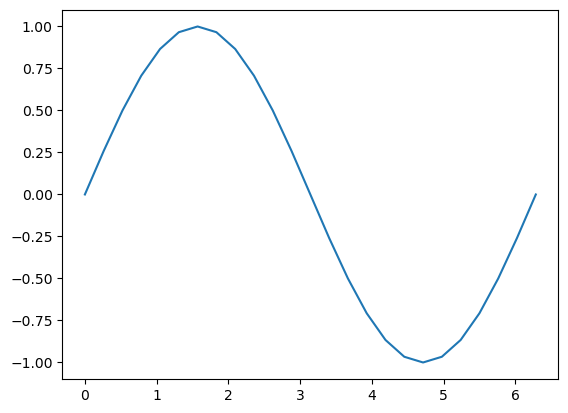

In [65]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

Let's have a closer look at the tensor b. When we print it, we see an indicator that it is tracking its computation history: 

In [66]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


This grad_fn gives us a hint that when we execute the backpropagation step and compute gradients, we’ll need to compute the derivative of 
sin
⁡
(
x
)
sin(x) for all this tensor’s inputs.

Let’s perform some more computations:

In [68]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Finally, let’s compute a single-element output. When you call .backward() on a tensor with no arguments, it expects the calling tensor to contain only a single element, as is the case when computing a loss function.

In [69]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


Each grad_fn stored with our tensors allows you to walk the computation all the way back to its inputs with its next_functions property. We can see below that drilling down on this property on d shows us the gradient functions for all the prior tensors. Note that a.grad_fn is reported as None, indicating that this was an input to the function with no history of its own.

In [70]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x32e0ccdf0>, 0), (None, 0))
((<SinBackward0 object at 0x32e0ccdf0>, 0), (None, 0))
((<AccumulateGrad object at 0x32e0cf970>, 0),)
()

c:

b:

a:
None


With all this machinery in place, how do we get derivatives out? You call the backward() method on the output, and check the input’s grad property to inspect the gradients:



tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


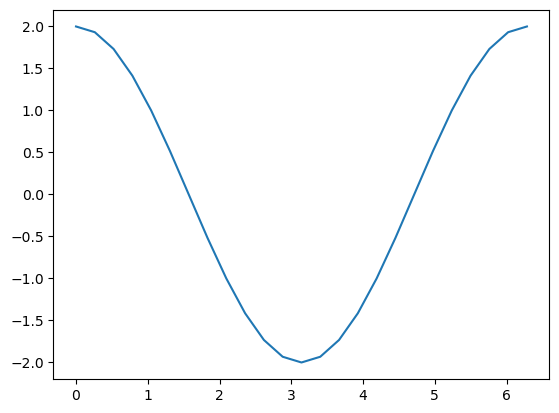

In [71]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

Recall the computations steps we took to get here:

In [72]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()

Adding a constant, as we did to compute d, does not change the derivative. That leaves c = 2 * b = 2 * sin(a), the derivative of which should be 2 * cos(a). Looking at the graph above, that's just what we see.

Be aware that only leaf nodes of the computation have their gradients computed. If you tried, for example , print(c.grad) you'd get back None. In this simple example, only the input is a leaf node, so only it has gradients computed.

### Autograd in Training

We’ve had a brief look at how autograd works, but how does it look when it’s used for its intended purpose? Let’s define a small model and examine how it changes after a single training batch. First, define a few constants, our model, and some stand-ins for inputs and outputs:



In [75]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(DIM_IN, HIDDEN_SIZE)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(HIDDEN_SIZE, DIM_OUT)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

One thing you might notice is that we never specify requires_grad=True for the model’s layers. Within a subclass of torch.nn.Module, it’s assumed that we want to track gradients on the layers’ weights for learning.

If we look at the layers of the model, we can examine the values of the weights, and verify that no gradients have been computed yet:

In [76]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

tensor([-0.0239,  0.0084, -0.0608,  0.0937, -0.0914,  0.0711,  0.0752,  0.0715,
        -0.0112, -0.0483], grad_fn=<SliceBackward0>)
None


Let’s see how this changes when we run through one training batch. For a loss function, we’ll just use the square of the Euclidean distance between our prediction and the ideal_output, and we’ll use a basic stochastic gradient descent optimizer.



In [77]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(153.8024, grad_fn=<SumBackward0>)


Now, let's call loss.backward() and see what happens:

In [78]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0239,  0.0084, -0.0608,  0.0937, -0.0914,  0.0711,  0.0752,  0.0715,
        -0.0112, -0.0483], grad_fn=<SliceBackward0>)
tensor([  0.8154,  -1.4623,  -4.0893,  -2.8619,  -0.3795, -10.1996,   4.3187,
         -1.0485,  -4.7910,   0.3056])


We can see that the gradients have been computed for each learning weight, but the weights remain unchanged, because we haven’t run the optimizer yet. The optimizer is responsible for updating model weights based on the computed gradients.

In [79]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0247,  0.0099, -0.0567,  0.0966, -0.0910,  0.0813,  0.0709,  0.0725,
        -0.0064, -0.0486], grad_fn=<SliceBackward0>)
tensor([  0.8154,  -1.4623,  -4.0893,  -2.8619,  -0.3795, -10.1996,   4.3187,
         -1.0485,  -4.7910,   0.3056])


You should see that layer2's weights have changed.

One important thing about the process: After calling optimizer.step(), you need to call optimzer.zero_grad(), or else every time you run loss.backward(),the gradients on the learning weights will accumulate:

In [80]:
print(model.layer2.weight.grad[0][0:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()

print(model.layer2.weight.grad[0][0:10])

optimizer.zero_grad(set_to_none=False)

print(model.layer2.weight.grad[0][0:10])

tensor([  0.8154,  -1.4623,  -4.0893,  -2.8619,  -0.3795, -10.1996,   4.3187,
         -1.0485,  -4.7910,   0.3056])
tensor([  1.8563,  -7.4775,  -8.3095, -15.9044,  15.7750, -47.1272,  21.3480,
         -7.5263, -24.6556,   1.0563])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


After running the cell above, you should see that after running loss.backward() multiple times, the magnitudes of most of the gradients will be much larger. Failing to zero the gradients before running your next training batch will cause the gradients to blow up in this manner, causing incorrect and unpredictable learning results.

### Turning Autograd Off and On

There are situations where you will need fine-grained control over whether autograd is enabled. There are multiple ways to do this, depending on the situation.

The simplest is to change the requires_grad flag on a tensor directly:

In [81]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


In the cell above, we see that b1 has a grad_fn (i.e., a traced computation history), which is what we expect, since it was derived from a tensor, a, that had autograd turned on. When we turn off autograd explicitly with a.requires_grad = False, computation history is no longer tracked, as we see when we compute b2.

If you only need autograd turned off temporarily, a better way is to use the torch.no_grad():

In [82]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


torch.no_grad() can also be used as a function or method decorator:

In [83]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


There’s a corresponding context manager, torch.enable_grad(), for turning autograd on when it isn’t already. It may also be used as a decorator.

Finally, you may have a tensor that requires gradient tracking, but you want a copy that does not. For this we have the Tensor object’s detach() method - it creates a copy of the tensor that is detached from the computation history:

In [84]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.4511, 0.0385, 0.8225, 0.4769, 0.6865], requires_grad=True)
tensor([0.4511, 0.0385, 0.8225, 0.4769, 0.6865])


### Building Models with PyTorch

torch.nn.Module and torch.nn.Parameter

One important behavior of torch.nn.Module is registering parameters. If a particular Module subclass has learning weights, these weights are expressed as instances of torch.nn.Parameter. The Parameter class is a subclass of torch.Tensor, with the special behavior that when they are assigned as attributes of a Module, they are added to the list of that modules parameters. These parameters may be accessed through the parameters() method on the Module class.



As a simple example, here’s a very simple model with two linear layers and an activation function. We’ll create an instance of it and ask it to report on its parameters:

In [85]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
Parameter containing:
tensor([[ 0.0269, -0.0572,  0.0371,  ..., -0.0579,  0.0048, -0.0493],
        [ 0.0512,  0.0596,  0.0321,  ...,  0.0242, -0.0196, -0.0885],
        [ 0.0633, -0.0711, -0.0552,  ...,  0.0622, -0.0284,  0.0644],
        ...,
        [ 0.0781,  0.0191, -0.0212,  ...,  0.0927, -0.0799,  0.0668],
        [-0.0997, -0.0837, -0.0199,  ..., -0.0828, -0.0227, -0.0799],
        [-0.0459,  0.0956, -0.0462,  ..., -0.0242, -0.0137, -0.0730]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0004, -0.0948,  0.0976, -0.0266, -0.0109, -0.0458,  0.0133, -0.0498,
         0.0078, -0.0184,  0.0256, -0.0189, -0.0244, -0.0322, -0.0227, -0.0082,
         0.0374,  0.0592, -0.0335, -0.05

This shows the fundamental structure of a PyTorch model: there is an __init__() method that defines the layers and other components of a model, and a forward() method where the computation gets done. Note that we can print the model, or any of its submodules, to learn about its structure.

### Common Layer Types

#### Linear Layers

The most basic type of neural network layer is a linear or fully connected layer. This is a layer where every input influences every output of the layer to a degree specified by the layer’s weights. If a model has m inputs and n outputs, the weights will be an m x n matrix. For example:

In [86]:
lin = torch.nn.Linear(3, 2)
x = torch.rand(1, 3)
print('Input:')
print(x)

print('\n\nWeight and Bias parameters:')
for param in lin.parameters():
    print(param)

y = lin(x)
print('\n\nOutput:')
print(y)

Input:
tensor([[0.2240, 0.8502, 0.0382]])


Weight and Bias parameters:
Parameter containing:
tensor([[0.4565, 0.4714, 0.2435],
        [0.4783, 0.2244, 0.3859]], requires_grad=True)
Parameter containing:
tensor([ 0.1042, -0.2300], requires_grad=True)


Output:
tensor([[0.6165, 0.0826]], grad_fn=<AddmmBackward0>)


If you do the matrix multiplication of x by the linear layer’s weights, and add the biases, you’ll find that you get the output vector y.

One other important feature to note: When we checked the weights of our layer with lin.weight, it reported itself as a Parameter (which is a subclass of Tensor), and let us know that it’s tracking gradients with autograd. This is a default behavior for Parameter that differs from Tensor.

Linear layers are used widely in deep learning models. One of the most common places you’ll see them is in classifier models, which will usually have one or more linear layers at the end, where the last layer will have n outputs, where n is the number of classes the classifier addresses.



#### Convolutional Layers

Convolutional layers are built to handle data with a high degree of spatial correlation. They are very commonly used in computer vision, where they detect close groupings of features which the compose into higher-level features. They pop up in other contexts too - for example, in NLP applications, where a word’s immediate context (that is, the other words nearby in the sequence) can affect the meaning of a sentence.



In [87]:
import torch.functional as F


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Let’s break down what’s happening in the convolutional layers of this model. Starting with conv1:

LeNet5 is meant to take in a 1x32x32 black & white image. The first argument to a convolutional layer’s constructor is the number of input channels. Here, it is 1. If we were building this model to look at 3-color channels, it would be 3.

A convolutional layer is like a window that scans over the image, looking for a pattern it recognizes. These patterns are called features, and one of the parameters of a convolutional layer is the number of features we would like it to learn. This is the second argument to the constructor is the number of output features. Here, we’re asking our layer to learn 6 features.

Just above, I likened the convolutional layer to a window - but how big is the window? The third argument is the window or kernel size. Here, the “5” means we’ve chosen a 5x5 kernel. (If you want a kernel with height different from width, you can specify a tuple for this argument - e.g., (3, 5) to get a 3x5 convolution kernel.)

The output of a convolutional layer is an activation map - a spatial representation of the presence of features in the input tensor. conv1 will give us an output tensor of 6x28x28; 6 is the number of features, and 28 is the height and width of our map. (The 28 comes from the fact that when scanning a 5-pixel window over a 32-pixel row, there are only 28 valid positions.)

We then pass the output of the convolution through a ReLU activation function (more on activation functions later), then through a max pooling layer. The max pooling layer takes features near each other in the activation map and groups them together. It does this by reducing the tensor, merging every 2x2 group of cells in the output into a single cell, and assigning that cell the maximum value of the 4 cells that went into it. This gives us a lower-resolution version of the activation map, with dimensions 6x14x14.

Our next convolutional layer, conv2, expects 6 input channels (corresponding to the 6 features sought by the first layer), has 16 output channels, and a 3x3 kernel. It puts out a 16x12x12 activation map, which is again reduced by a max pooling layer to 16x6x6. Prior to passing this output to the linear layers, it is reshaped to a 16 * 6 * 6 = 576-element vector for consumption by the next layer.

There are convolutional layers for addressing 1D, 2D, and 3D tensors. There are also many more optional arguments for a conv layer constructor, including stride length(e.g., only scanning every second or every third position) in the input, padding (so you can scan out to the edges of the input), and more. See the documentation for more information.



### Recurrent Layers

Recurrent neural networks (or RNNs) are used for sequential data - anything from time-series measurements from a scientific instrument to natural language sentences to DNA nucleotides. An RNN does this by maintaining a hidden state that acts as a sort of memory for what it has seen in the sequence so far.

The internal structure of an RNN layer - or its variants, the LSTM (long short-term memory) and GRU (gated recurrent unit) - is moderately complex and beyond the scope of this video, but we’ll show you what one looks like in action with an LSTM-based part-of-speech tagger (a type of classifier that tells you if a word is a noun, verb, etc.):



In [88]:
class LSTMTagger(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = torch.nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

The constructor has four arguments:

vocab_size is the number of words in the input vocabulary. Each word is a one-hot vector (or unit vector) in a vocab_size-dimensional space.

tagset_size is the number of tags in the output set.

embedding_dim is the size of the embedding space for the vocabulary. An embedding maps a vocabulary onto a low-dimensional space, where words with similar meanings are close together in the space.

hidden_dim is the size of the LSTM’s memory.

The input will be a sentence with the words represented as indices of one-hot vectors. The embedding layer will then map these down to an embedding_dim-dimensional space. The LSTM takes this sequence of embeddings and iterates over it, fielding an output vector of length hidden_dim. The final linear layer acts as a classifier; applying log_softmax() to the output of the final layer converts the output into a normalized set of estimated probabilities that a given word maps to a given tag.



### Transformers

Transformers are multi-purpose networks that have taken over the state of the art in NLP with models like BERT. A discussion of transformer architecture is beyond the scope of this video, but PyTorch has a Transformer class that allows you to define the overall parameters of a transformer model - the number of attention heads, the number of encoder & decoder layers, dropout and activation functions, etc. (You can even build the BERT model from this single class, with the right parameters!) The torch.nn.Transformer class also has classes to encapsulate the individual components (TransformerEncoder, TransformerDecoder) and subcomponents (TransformerEncoderLayer, TransformerDecoderLayer).

### Other Layers and Functions

#### Data Manipulation Layers

There are other layer types that perform important functions in models, but don’t participate in the learning process themselves.

Max pooling (and its twin, min pooling) reduce a tensor by combining cells, and assigning the maximum value of the input cells to the output cell (we saw this). For example:

In [89]:
my_tensor = torch.rand(1, 6, 6)
print(my_tensor)

maxpool_layer = torch.nn.MaxPool2d(3)
print(maxpool_layer(my_tensor))

tensor([[[0.3224, 0.3377, 0.6741, 0.1029, 0.4638, 0.4790],
         [0.2881, 0.5509, 0.2951, 0.4853, 0.7459, 0.7176],
         [0.1691, 0.4626, 0.7202, 0.0369, 0.5813, 0.1516],
         [0.2189, 0.5179, 0.0519, 0.0983, 0.5620, 0.2256],
         [0.9773, 0.4204, 0.2714, 0.3087, 0.7568, 0.6110],
         [0.4765, 0.8580, 0.8190, 0.9481, 0.5266, 0.3538]]])
tensor([[[0.7202, 0.7459],
         [0.9773, 0.9481]]])


If you look closely at the values above, you’ll see that each of the values in the maxpooled output is the maximum value of each quadrant of the 6x6 input.

Normalization layers re-center and normalize the output of one layer before feeding it to another. Centering and scaling the intermediate tensors has a number of beneficial effects, such as letting you use higher learning rates without exploding/vanishing gradients.



In [90]:
my_tensor = torch.rand(1, 4, 4) * 20 + 5
print(my_tensor)

print(my_tensor.mean())

norm_layer = torch.nn.BatchNorm1d(4)
normed_tensor = norm_layer(my_tensor)
print(normed_tensor)

print(normed_tensor.mean())

tensor([[[19.5715, 12.8166, 19.7759, 21.2435],
         [ 8.5956, 19.6041, 12.2709,  7.7482],
         [ 7.8302, 16.3638, 17.3497, 16.2224],
         [15.9994, 18.0637, 24.4571, 17.9766]]])
tensor(15.9931)
tensor([[[ 0.3741, -1.6978,  0.4368,  0.8869],
         [-0.7394,  1.6137,  0.0462, -0.9205],
         [-1.7209,  0.5004,  0.7570,  0.4636],
         [-0.9803, -0.3327,  1.6730, -0.3600]]],
       grad_fn=<NativeBatchNormBackward0>)
tensor(8.1956e-08, grad_fn=<MeanBackward0>)


Running the cell above, we’ve added a large scaling factor and offset to an input tensor; you should see the input tensor’s mean() somewhere in the neighborhood of 15. After running it through the normalization layer, you can see that the values are smaller, and grouped around zero - in fact, the mean should be very small (> 1e-8).

This is beneficial because many activation functions (discussed below) have their strongest gradients near 0, but sometimes suffer from vanishing or exploding gradients for inputs that drive them far away from zero. Keeping the data centered around the area of steepest gradient will tend to mean faster, better learning and higher feasible learning rates.

Dropout layers are a tool for encouraging sparse representations in your model - that is, pushing it to do inference with less data.

Dropout layers work by randomly setting parts of the input tensor during training - dropout layers are always turned off for inference. This forces the model to learn against this masked or reduced dataset. For example:



In [91]:
my_tensor = torch.rand(1, 4, 4)

dropout = torch.nn.Dropout(p=0.4)
print(dropout(my_tensor))
print(dropout(my_tensor))

tensor([[[0.0000, 0.0000, 0.1841, 0.0000],
         [1.2755, 0.0000, 1.0831, 0.0000],
         [0.8027, 0.5163, 0.3240, 0.0000],
         [0.0000, 0.5399, 0.0000, 0.8007]]])
tensor([[[0.0000, 0.0000, 0.1841, 0.5716],
         [1.2755, 0.0000, 1.0831, 0.0000],
         [0.8027, 0.0000, 0.3240, 0.4346],
         [0.0000, 0.5399, 0.0000, 0.0000]]])


Above, you can see the effect of dropout on a sample tensor. You can use the optional p argument to set the probability of an individual weight dropping out; if you don’t it defaults to 0.5.

### Activation Functions

Activation functions make deep learning possible. A neural network is really a program - with many parameters - that simulates a mathematical function. If all we did was multiple tensors by layer weights repeatedly, we could only simulate linear functions; further, there would be no point to having many layers, as the whole network would reduce could be reduced to a single matrix multiplication. Inserting non-linear activation functions between layers is what allows a deep learning model to simulate any function, rather than just linear ones.

torch.nn.Module has objects encapsulating all of the major activation functions including ReLU and its many variants, Tanh, Hardtanh, sigmoid, and more. It also includes other functions, such as Softmax, that are most useful at the output stage of a model.



### Loss Functions

Loss functions tell us how far a model’s prediction is from the correct answer. PyTorch contains a variety of loss functions, including common MSE (mean squared error = L2 norm), Cross Entropy Loss and Negative Likelihood Loss (useful for classifiers), and others.

### PyTorch TensorBoard Support

Before You Start
To run this tutorial, you’ll need to install PyTorch, TorchVision, Matplotlib, and TensorBoard.

With conda:
conda install pytorch torchvision -c pytorch
conda install matplotlib tensorboard

With pip:
pip install torch torchvision matplotlib tensorboard

### Introduction

In this notebook, we’ll be training a variant of LeNet-5 against the Fashion-MNIST dataset. Fashion-MNIST is a set of image tiles depicting various garments, with ten class labels indicating the type of garment depicted.

In [98]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

# In case you are using an environment that has TensorFlow installed,
# such as Google Colab, uncomment the following code to avoid
# a bug with saving embeddings to your TensorBoard directory

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

### Showing Images in TensorBoard

Let's start by adding sample images from our dataset to TensorBoard:

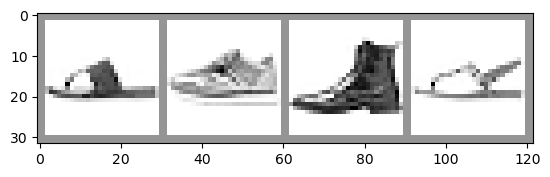

In [99]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Above, we used TorchVision and Matplotlib to create a visual grid of a minibatch of our input data. Below, we use the add_image() call on SummaryWriter to log the image for consumption by TensorBoard, and we also call flush() to make sure it’s written to disk right away.

In [100]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

If you start TensorBoard at the command line and open it in a new browser tab (usually at localhost:6006), you should see the image grid under the IMAGES tab.

### Graphing scalars to Visualize Training

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we’ll run a training loop, track some metrics, and save the data for TensorBoard’s consumption.

Let’s define a model to categorize our image tiles, and an optimizer and loss function for training:

In [101]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Now let's train a single epocg, and evaluate the training vs. validation set losses every 1000 batches:

In [102]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            net.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


switch to your open TensorBoard and have a look at the SCALARS tab.

### Visualize Your Model

TensorBoard can also be used to examine the data flow within your model. To do this, call the add_graph() method with a model and sample input:

In [103]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

When you switch over to TensorBoard, you should see a GRAPHS tab. Double-click the “NET” node to see the layers and data flow within your model.



### Visualize Your Dataset With Embeddings

The 28-by-28 image tiles we’re using can be modeled as 784-dimensional vectors (28 * 28 = 784). It can be instructive to project this to a lower-dimensional representation. The add_embedding() method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart. The add_embedding() method does this automatically by projecting to the three dimensions with highest variance.

Below, we’ll take a sample of our data, and generate such an embedding:

In [104]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

Now if you switch to TensorBoard and select the PROJECTOR tab, you should see a 3D representation of the projection. You can rotate and zoom the model. Examine it at large and small scales, and see whether you can spot patterns in the projected data and the clustering of labels.

For better visibility, it’s recommended to:

Select “label” from the “Color by” drop-down on the left.

Toggle the Night Mode icon along the top to place the light-colored images on a dark background.

### Training with Pytorch

we’ve discussed and demonstrated:

Building models with the neural network layers and functions of the torch.nn module

The mechanics of automated gradient computation, which is central to gradient-based model training

Using TensorBoard to visualize training progress and other activities

Here, we’ll be adding some new tools to your inventory:

We’ll get familiar with the dataset and dataloader abstractions, and how they ease the process of feeding data to your model during a training loop

We’ll discuss specific loss functions and when to use them

We’ll look at PyTorch optimizers, which implement algorithms to adjust model weights based on the outcome of a loss function

Finally, we’ll pull all of these together and see a full PyTorch training loop in action.

### Dataset and DataLoader

The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The Dataset is responsible for accessing and processing single instances of data.

The DataLoader pulls instances of data from the Dataset (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The DataLoader works with all kinds of datasets, regardless of the type of data they contain.

For this tutorial, we’ll be using the Fashion-MNIST dataset provided by TorchVision. We use torchvision.transforms.Normalize() to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

In [105]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


as always, let's visualize the data as a sanity check:

Ankle Boot  Dress  Sneaker  Pullover


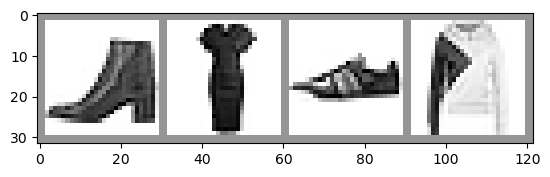

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### The Model
The model we'll use in this example is a variant of LeNet-5 

In [107]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

### Loss Function

For this example, we’ll be using a cross-entropy loss. For demonstration purposes, we’ll create batches of dummy output and label values, run them through the loss function, and examine the result.

In [108]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.1966, 0.7977, 0.5737, 0.1013, 0.7882, 0.1922, 0.6714, 0.8853, 0.9169,
         0.1052],
        [0.9903, 0.7030, 0.2487, 0.7148, 0.5824, 0.1114, 0.8666, 0.7997, 0.7809,
         0.2232],
        [0.9658, 0.6763, 0.4772, 0.7458, 0.1240, 0.7907, 0.8089, 0.8651, 0.5805,
         0.5930],
        [0.0895, 0.6302, 0.5365, 0.2451, 0.5431, 0.5948, 0.9977, 0.2078, 0.6073,
         0.2784]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.4384467601776123


### Optimizer

For this example, we’ll be using simple stochastic gradient descent with momentum.

It can be instructive to try some variations on this optimization scheme:

Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to the your training results, in terms of accuracy and convergence time?

Momentum nudges the optimizer in the direction of strongest gradient over multiple steps. What does changing this value do to your results?

Try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam. How do your results differ?

In [109]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### The Training Loop

Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

Gets a batch of training data from the DataLoader

Zeros the optimizer’s gradients

Performs an inference - that is, gets predictions from the model for an input batch

Calculates the loss for that set of predictions vs. the labels on the dataset

Calculates the backward gradients over the learning weights

Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

It reports on the loss for every 1000 batches.

Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [110]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity

There are a couple of things we’ll want to do once per epoch:

Perform validation by checking our relative loss on a set of data that was not used for training, and report this

Save a copy of the model

Here, we’ll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [111]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.1717964600920676
  batch 2000 loss: 0.9321752298176289
  batch 3000 loss: 0.7051929750447161
  batch 4000 loss: 0.6380287983976305
  batch 5000 loss: 0.5825936196520924
  batch 6000 loss: 0.5695326576875522
  batch 7000 loss: 0.522997462703148
  batch 8000 loss: 0.5104436654730234
  batch 9000 loss: 0.49308474537244185
  batch 10000 loss: 0.4952390701759141
  batch 11000 loss: 0.4624113521499312
  batch 12000 loss: 0.4444122429790441
  batch 13000 loss: 0.4385216388797271
  batch 14000 loss: 0.4278125356932869
  batch 15000 loss: 0.39571767111937517
LOSS train 0.39571767111937517 valid 0.4296651780605316
EPOCH 2:
  batch 1000 loss: 0.3822799964947626
  batch 2000 loss: 0.3802146837072214
  batch 3000 loss: 0.4082624550810433
  batch 4000 loss: 0.3747677474583252
  batch 5000 loss: 0.37915061244531534
  batch 6000 loss: 0.37926533519421357
  batch 7000 loss: 0.38140475272962066
  batch 8000 loss: 0.38034670303331225
  batch 9000 loss: 0.35105618538991257
  

To load a saved version of the model

In [112]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))

NameError: name 'PATH' is not defined

Once you’ve loaded the model, it’s ready for whatever you need it for - more training, inference, or analysis.

Note that if your model has constructor parameters that affect model structure, you’ll need to provide them and configure the model identically to the state in which it was saved.



### Model Understanding with Captum